In [5]:
%load_ext tensorboard
%pip install kagglehub
%pip install os numpy matplotlib
%pip install random
%pip install tensorflow
%pip install opencv-python
%pip install seaborn

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages

In [6]:
import os
import shutil
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 1. DATA PIPELINE #

In [ ]:
image_root_dir = "./images"
print("Path to dataset files:", image_root_dir)

csv_path = "./metadata34.csv"
metadata_df = pd.read_csv(csv_path, sep=';', names=["filename", "label", "split", "original"], header=0)

metadata_df['filename'] = metadata_df['filename'].str.replace('.mp4', '', regex=False)
metadata_df['filepath'] = metadata_df['filename'].apply(lambda f: os.path.join(image_root_dir, f))
filename_to_label = dict(zip(metadata_df['filename'], metadata_df['label']))


all_paths = metadata_df['filepath'].tolist()
random.shuffle(all_paths)



# train/val/test split

In [8]:
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
n = len(all_paths)
i_train = int(n * train_ratio)
i_val   = int(n * (train_ratio + val_ratio))

train_images = all_paths[:i_train]
val_images   = all_paths[i_train:i_val]
test_images  = all_paths[i_val:]

print(f"Train: {len(train_images)} images\n"
      f"Validation: {len(val_images)} images\n"
      f"Test: {len(test_images)} images")


Train: 1861 images
Validation: 399 images
Test: 399 images


In [9]:
def prepare_dir(split_list, split_name):
    if os.path.exists(split_name):
        shutil.rmtree(split_name)
    for lbl in ['FAKE', 'REAL']:
        os.makedirs(os.path.join(split_name, lbl), exist_ok=True)

    for folder_path in split_list:
        folder_name = os.path.basename(folder_path)
        label = filename_to_label.get(folder_name)

        if not os.path.isdir(folder_path):
            print(f"Folder can not be found: {folder_path}")
            continue

 
        for file in os.listdir(folder_path):
            img_file_path = os.path.join(folder_path, file)
            if not os.path.isfile(img_file_path):
                continue
            if label:
                dst = os.path.join(split_name, label.upper(), f"{folder_name}_{file}")
                shutil.copy(img_file_path, dst)

prepare_dir(train_images, 'train_directory')
prepare_dir(val_images,   'val_directory')
prepare_dir(test_images,  'test_directory')



Folder can not be found: /Users/kivilcimnazboke/Desktop/MesudeGKivilcimNazBHW3/images/filename


# normalise, resize (≤ 224 × 224)

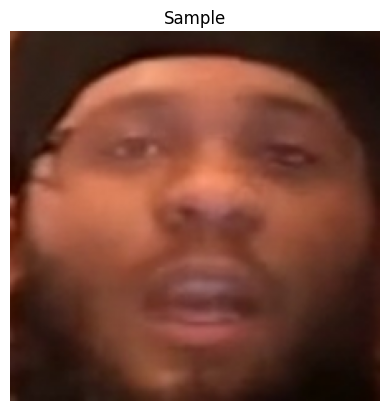

In [10]:
def process_image(image_path):
    img = Image.open(image_path).resize((224,224)) #resize 
    arr = np.array(img) / 255.0 #normalize
    return arr

def get_sample_image_from_folder(folder_path):
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            return os.path.join(folder_path, file)
    return None

#print a sample
sample_image_path = get_sample_image_from_folder(train_images[0])

if sample_image_path:
    sample = process_image(sample_image_path)
    plt.imshow(sample); plt.title("Sample"); plt.axis('off'); plt.show()
else:
    print("None of the image file can not be found.")


# 2-3. MODEL + EXPERIMENT MANAGEMENT 

In [11]:
%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
#freeze base → fine-tune head
def create_model(input_shape=(224,224,3)):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for l in base.layers:
        l.trainable = False #freeze base
    x = GlobalAveragePooling2D()(base.output) #fine-tune head
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  #%50 dropout
    out = Dense(1, activation='sigmoid')(x)
    return Model(base.input, out)

model = create_model()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'train_directory',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    'val_directory',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

log_dir = "logs/fit"
checkpoint_path = "models/best_model.h5"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,  
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[tensorboard_callback, checkpoint_callback]  
)

#unfreeze
for layer in model.layers:
    layer.trainable = True  

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_gen,
    epochs=5,  
    validation_data=val_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[tensorboard_callback, checkpoint_callback]  
)

test_gen = val_datagen.flow_from_directory(
    'test_directory',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

best_model = load_model("models/best_model.h5")
loss, acc = best_model.evaluate(test_gen, steps=1)
print(f"Test Accuracy: {acc * 100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 18610 images belonging to 2 classes.
Found 3990 images belonging to 2 classes.


/Users/kivilcimnazboke/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8280 - loss: 0.4428
Epoch 1: val_loss improved from inf to 0.38793, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 7172s 3s/step - accuracy: 0.8281 - loss: 0.4428 - val_accuracy: 0.8587 - val_loss: 0.3879
Epoch 2/5
   1/2326 ━━━━━━━━━━━━━━━━━━━━ 52:42 1s/step - accuracy: 1.0000 - loss: 0.1774

/Users/kivilcimnazboke/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.38793 to 0.38702, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 630s 270ms/step - accuracy: 1.0000 - loss: 0.1774 - val_accuracy: 0.8584 - val_loss: 0.3870
Epoch 3/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8445 - loss: 0.4082
Epoch 3: val_loss improved from 0.38702 to 0.36997, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 3740s 2s/step - accuracy: 0.8445 - loss: 0.4082 - val_accuracy: 0.8647 - val_loss: 0.3700
Epoch 4/5
   1/2326 ━━━━━━━━━━━━━━━━━━━━ 1:01:49 2s/step - accuracy: 0.8750 - loss: 0.2452
Epoch 4: val_loss did not improve from 0.36997
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 659s 283ms/step - accuracy: 0.8750 - loss: 0.2452 - val_accuracy: 0.8637 - val_loss: 0.3702
Epoch 5/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8464 - loss: 0.4060
Epoch 5: val_loss did not improve from 0.36997
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 3974s 2s/step - accuracy: 0.8464 - loss: 0.4060 - val_accuracy: 0.8665 - val_loss: 0.3724
Epoch 1/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8759 - loss: 0.3338
Epoch 1: val_loss improved from 0.36997 to 0.14963, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 18251s 8s/step - accuracy: 0.8759 - loss: 0.3338 - val_accuracy: 0.9443 - val_loss: 0.1496
Epoch 2/5
   1/2326 ━━━━━━━━━━━━━━━━━━━━ 2:31:26 4s/step - accuracy: 1.0000 - loss: 0.0356
Epoch 2: val_loss did not improve from 0.14963
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 571s 244ms/step - accuracy: 1.0000 - loss: 0.0356 - val_accuracy: 0.9440 - val_loss: 0.1509
Epoch 3/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9470 - loss: 0.1488 
Epoch 3: val_loss improved from 0.14963 to 0.12291, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 25336s 11s/step - accuracy: 0.9470 - loss: 0.1488 - val_accuracy: 0.9546 - val_loss: 0.1229
Epoch 4/5
   1/2326 ━━━━━━━━━━━━━━━━━━━━ 4:15:57 7s/step - accuracy: 1.0000 - loss: 0.0368
Epoch 4: val_loss improved from 0.12291 to 0.12061, saving model to models/best_model.h5


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 1047s 448ms/step - accuracy: 1.0000 - loss: 0.0368 - val_accuracy: 0.9546 - val_loss: 0.1206
Epoch 5/5
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9644 - loss: 0.1052 
Epoch 5: val_loss did not improve from 0.12061
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 30850s 13s/step - accuracy: 0.9644 - loss: 0.1052 - val_accuracy: 0.9423 - val_loss: 0.1452
Found 3980 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8750 - loss: 0.2041
Test Accuracy: 87.50%


# 4. EVALUATION

498/498 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step
AUC-ROC: 0.9743


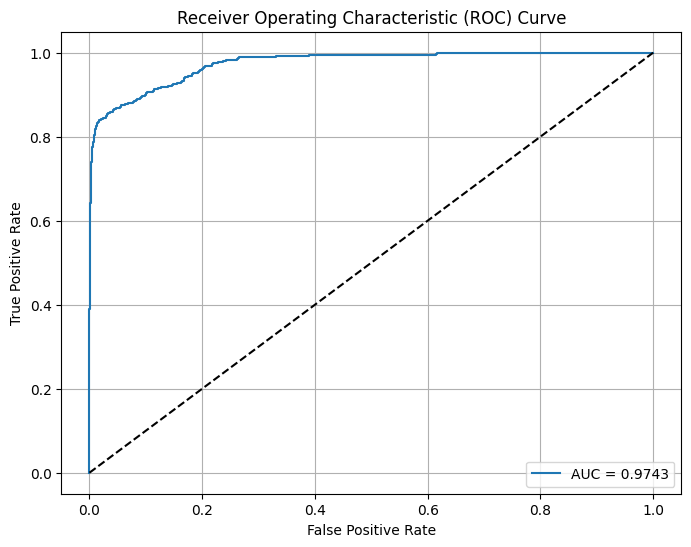

Accuracy: 0.9658
F1-score: 0.8687


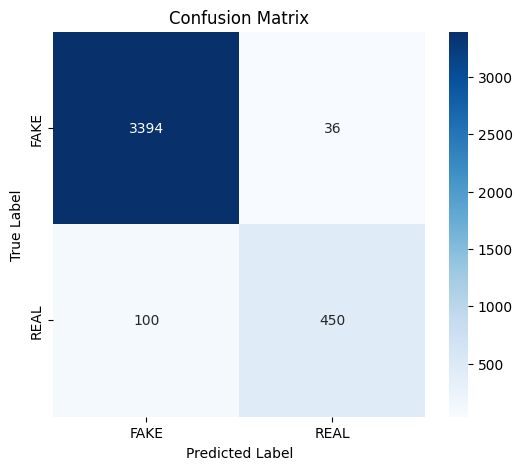

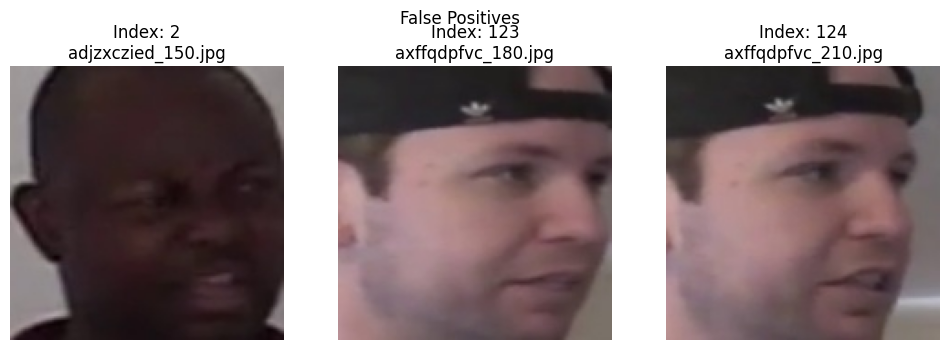

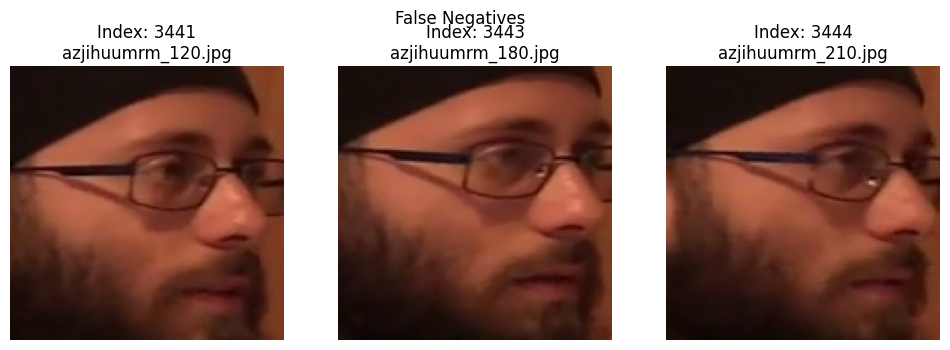

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
import seaborn as sns

y_true = test_gen.classes
y_prob = best_model.predict(test_gen, verbose=1)
y_pred = (y_prob > 0.5).astype(int).reshape(-1)


auc_score = roc_auc_score(y_true, y_prob)
print(f"AUC-ROC: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


acc_score = np.mean(y_pred == y_true)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {acc_score:.4f}")
print(f"F1-score: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]  
fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]  

def plot_errors(indices, title):
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(indices[:3]):  
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"Index: {idx}\n{os.path.basename(img_path)}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_errors(fp_indices, "False Positives")
plot_errors(fn_indices, "False Negatives")